In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-music/yellow_coldplay.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/README.txt
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/checksums
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135004.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135369.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135374.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135039.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135229.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135364.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135037.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135337.mp3
/kaggle/input/fma-free-music-archive-small-medium/fma_medium/fma_medium/135/135811.mp3
/kaggle

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import joblib
from tqdm import tqdm

data_dir = "/kaggle/input/fma-free-music-archive-small-medium/fma_small"  

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        features = np.hstack([mfcc, chroma, contrast])
        return features
    except Exception as e:
        print(f"Error extracting {file_path}: {e}")
        return None


features = []
filenames = []

for root, dirs, files in os.walk(data_dir):
    for file in tqdm(files):
        if file.endswith(".mp3"):
            path = os.path.join(root, file)
            feat = extract_features(path)
            if feat is not None and len(feat) > 0:
                features.append(feat)
                filenames.append(path)

print(f"Extracted features from {len(features)} files.")

X = np.array(features)


kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X)

df = pd.DataFrame(X)
df['filename'] = filenames
df['cluster'] = clusters


joblib.dump(kmeans, 'kmeans_model.pkl')
np.save('features.npy', X)
with open('filenames.txt', 'w') as f:
    for fn in filenames:
        f.write(fn + '\n')
with open('clusters.txt', 'w') as f:
    for c in clusters:
        f.write(str(c) + '\n')

print("Model and data saved!")


In [2]:
import numpy as np
import pandas as pd
import joblib


kmeans = joblib.load('/kaggle/input/temporary-files/kmeans_model.pkl')
X = np.load('/kaggle/input/temporary-files/features.npy')
with open('/kaggle/input/temporary-files/filenames.txt') as f:
    filenames = f.read().splitlines()
with open('/kaggle/input/temporary-files/clusters.txt') as f:
    clusters = list(map(int, f.read().splitlines()))


df = pd.DataFrame(X)
df['filename'] = filenames
df['cluster'] = clusters


num_clusters = kmeans.n_clusters
print(f"Number of clusters: {num_clusters}")

for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id} example songs:")
    example_songs = df[df['cluster'] == cluster_id]['filename'].head(5)
    for song in example_songs:
        print(f" - {song}")


Number of clusters: 10

Cluster 0 example songs:
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135229.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135054.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/057/057936.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/057/057939.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/057/057418.mp3

Cluster 1 example songs:
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135340.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135221.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135227.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135368.mp3
 - /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/135/135222.mp3

Cluster 2 example songs:
 - /kaggle/input/fm

Silhouette Score: 0.187
Davies-Bouldin Index: 1.380
Calinski-Harabasz Score: 3814.700


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

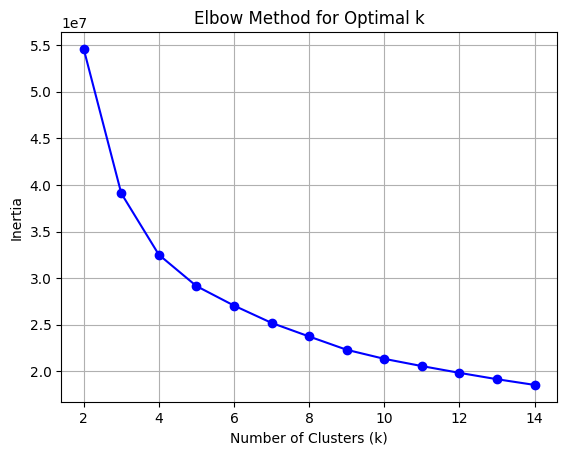

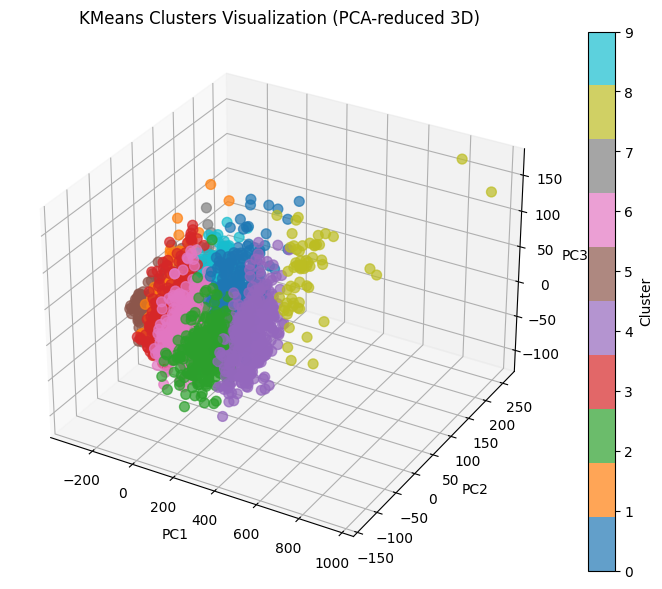

In [3]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  


score = silhouette_score(X, clusters)
print(f"Silhouette Score: {score:.3f}")

from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(X, clusters)
print(f"Davies-Bouldin Index: {db_index:.3f}")

from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X, clusters)
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 15)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

plt.plot(k_range, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()



pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Plot 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
    c=clusters, cmap='tab10', s=50, alpha=0.7
)

ax.set_title("KMeans Clusters Visualization (PCA-reduced 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.show()


In [4]:
import librosa
import numpy as np

file_path = "/kaggle/input/test-music/yellow_coldplay.mp3"  

try:
    y, sr = librosa.load(file_path, duration=30)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    features = np.hstack([mfcc, chroma, contrast])

    print("Features extracted successfully!")
    print("Feature shape:", features.shape)
    print("First few features:", features[:5])
except Exception as e:
    print(" Error:", e)
import joblib


kmeans = joblib.load("/kaggle/input/temporary-files/kmeans_model.pkl")

predicted_cluster = kmeans.predict(features.reshape(1, -1))[0]
print(f"\n Predicted cluster: {predicted_cluster}")


Features extracted successfully!
Feature shape: (32,)
First few features: [-64.10596466  98.993927     2.23309827  32.15633774   4.76692963]

 Predicted cluster: 1
